In [12]:
import os, sys, pdb, shutil, random, math, cv2, datetime
import _pickle as cPickle
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import OrderedDict, namedtuple
from PIL import Image

from dataloaders.Classification_Image import OCT_image_classification, OCT_classification_persample
from dataloaders.Segmentation_Image import OCT_image_segmentation, OCT_segmentation_persample, natural_keys
import dataloaders.Segmentation_test_transforms as test_tr
from networks.segmentation.deeplab_xception import DeepLabv3_plus_xception
from networks.segmentation.deeplab_resnet import DeepLabv3_plus_resnet

import dataloaders.Image_transforms as Image_tr
from networks.classification.ResNet_original import ResNet34_original, ResNet50_original, ResNet18_original
from networks.classification.DenseNet_original import DenseNet121_original

from dataloaders.Image_utils import decode_segmap, decode_segmap_sequence
#from utils import aic_fundus_lesion_segmentation
from tqdm import tqdm

In [13]:
def seg_predict_ensemble(models, inputs, device, test_scales, is_flip):
    with torch.no_grad():
        original_w, original_h = inputs.size(-1), inputs.size(-2)
        outputs = []
        to_flip = [True, False] if is_flip else [False]
        inputs_arr = inputs.detach().cpu().numpy()
        for model in models:
            model.eval()
            for scale in test_scales:
                for flip in to_flip:
                    aug_images = aug_batch_inputs(inputs_arr, scale, flip)
                    aug_images = np.expand_dims(aug_images, 1)# add the channel dimension
                    aug_images = torch.from_numpy(aug_images).float().to(device)
                    aug_outputs = model(aug_images)
                    aug_outputs = F.softmax(aug_outputs, dim=1)
                    restored_outputs = aug_restore(aug_outputs.detach().cpu().numpy(), original_w, original_h, flip)
                    outputs.append(restored_outputs)
        ensemble = np.mean(np.stack(outputs), 0)
    return ensemble

def aug_restore(batch_outputs, target_w, target_h, is_flip):
    """restore the augmented output to target width and height"""
    assert len(batch_outputs.shape) == 4
    batch_size, num_channel = batch_outputs.shape[0], batch_outputs.shape[1]
    restored_outputs = np.empty((batch_size, num_channel, target_h, target_w))
    for image_idx in range(batch_size):
        image = np.transpose(batch_outputs[image_idx], [1, 2, 0])
        image = cv2.resize(image, (target_w, target_h), interpolation = cv2.INTER_LINEAR)
        if is_flip:
            image = cv2.flip(image, 1)
        restored_outputs[image_idx] = np.transpose(image, [2, 0, 1])
    return restored_outputs   

def seg_main(models, dataloader, device, test_scales, is_flip):
    samples, sample_predictions = [], []
    for inputs in dataloader:
        output_ensemble = seg_predict_ensemble(models, inputs, device, test_scales, is_flip)
        predictions = np.argmax(output_ensemble, 1)
        samples.append(inputs.cpu().numpy())
        sample_predictions.append(predictions)
    return np.concatenate(samples, 0), np.concatenate(sample_predictions, 0)

def aug_batch_inputs(batch_inputs, scale, is_flip):
    """augment a batch of image"""
    assert len(batch_inputs.shape) == 4
    batch_size, original_w, original_h = batch_inputs.shape[0], batch_inputs.shape[-1], batch_inputs.shape[-2]
    target_w, target_h = int(original_w*scale), int(original_h*scale)
    batch_images = np.squeeze(batch_inputs, 1) # remove the channel dimension
    auged_images = np.empty((batch_size, target_h, target_w))
    for image_idx in range(batch_size):
        image = batch_images[image_idx]
        image = cv2.resize(image, (target_w, target_h), interpolation = cv2.INTER_LINEAR)
        if is_flip:
            image = cv2.flip(image, 1)
        auged_images[image_idx] = image
    return auged_images

In [14]:
def vanilla_seg(root_path, seg_models, seg_tr, device, batch_size, num_workers, test_scales, is_flip):
    sample_images, sample_predictions, sample_names = [], [], []
    for sample_name in tqdm(sorted(os.listdir(root_path))):
#         sample_names.append(sample_name.replace(".img", ""))
        sample_path = os.path.join(root_path, sample_name)
        seg_dataset = OCT_segmentation_persample(sample_path, transform = seg_tr)
        seg_datasetloader = torch.utils.data.DataLoader(seg_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers)
        images, predictions = seg_main(seg_models, seg_datasetloader, device, test_scales, is_flip)
        sample_images.append(images)
        sample_predictions.append(predictions)
    return sample_images, sample_predictions, sample_names

In [15]:
class Config(object):
    def __init__(self):
        
        self.label_dict = OrderedDict([(0, 0), (255, 1), (191, 2), (128, 3)])
        self.gpus = "1"
        self.os = 16
        self.n_classes = 4
        self.batch_size = 1
        
        self.num_workers = 8

config = Config()

In [16]:
def load_model(network, backbone, checkpoint_path, device, gpus, os, n_classes = 4):
    model = globals()[network](nInputChannels=1, n_classes=n_classes, os=os, backbone=backbone, checkpoint=None, ignore_prefixs = [])
    print("Load %s"%(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
    if "state_dict" in checkpoint.keys():
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "") # remove `module.`
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict)
    if device!='cpu' and len(gpus) > 1:
        model = nn.DataParallel(model, gpus)
    model.to(device)
    return model

In [17]:
gpus = list(map(int, config.gpus.split(",")))
device = 'cuda:1'

# ResNet101, checkpoint/segmentation/DeepLabv3_plus_resnet/aug_512_1024/epoch13.pth
# ResNet50, checkpoint/segmentation/DeepLabv3_plus_resnet/aug_classweight_1_1_1.5_10/epoch34.pth
# ResNet50, checkpoint/segmentation/DeepLabv3_plus_resnet/aug_dice_scale_0.75_1.5_weight_1_1.5_1.5_6/epoch31.pth

seg_models = [load_model("DeepLabv3_plus_resnet", "ResNet50", "checkpoint/segmentation/DeepLabv3_plus_resnet/Edema_sizeAvg_aug_1024x512_cross_entropy_scale_0.75_1.5_weight_1_1.5_1.5_10/epoch46.pth", 
               device, gpus, 16, config.n_classes)]

seg_tr = transforms.Compose([
        test_tr.Normalize_divide(255.0),
        test_tr.ToTensor()])

root_path = "/opt/models/AIChallenger_OCT/data/Edema_testset_1/original_images"

sample_images, sample_predictions, sample_names = vanilla_seg(root_path, seg_models, seg_tr, device, 
                                                              batch_size=config.batch_size, num_workers=config.num_workers,
                                                              test_scales = [0.5, 0.75, 1.0, 1.25, 1.50, 1.75], is_flip = True)


Constructing DeepLabv3+ model...
Number of classes: 4
Output stride: 16
Number of Input Channels: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Load checkpoint/segmentation/DeepLabv3_plus_resnet/Edema_sizeAvg_aug_1024x512_cross_entropy_scale_0.75_1.5_weight_1_1.5_1.5_10/epoch46.pth


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2925: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


In [8]:
torch.cuda.empty_cache()

In [ ]:
def save_pickle(obj, save_path): 
    parent_path = os.path.dirname(save_path)  # get parent path
    if not os.path.exists(parent_path):
        os.makedirs(parent_path)
    cPickle.dump(obj, open(save_path, "wb"), True)
save_pickle(sample_names, "./predictions/pickles/20220724/sample_names_epoch46.pkl")
save_pickle(sample_predictions, "./predictions/pickles/20220724/segmentation_sample_predictions_epoch46.pkl")

In [6]:
def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as fo:
        pickle_dict = cPickle.load(fo)
    return pickle_dict  
sample_names = load_pickle("./predictions/pickles/20220724/sample_names_epoch46.pkl")
sample_predictions = load_pickle("./predictions/pickles/20220724/segmentation_sample_predictions_epoch46.pkl")

In [12]:
def replace_pixel(sample_predictions, source_pixel, target_pixel):
    """replace source pixel with target pixel in sample prediction """
    replaced_predictions = []
    for sample_prediction in sample_predictions:
        np.place(sample_prediction, sample_prediction==source_pixel, target_pixel)
        replaced_predictions.append(sample_prediction)
    return replaced_predictions
sample_predictions = replace_pixel(sample_predictions, 2, 0)
sample_predictions = replace_pixel(sample_predictions, 3, 0)

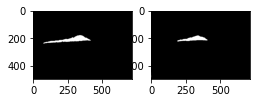

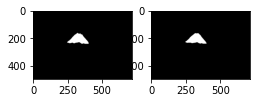

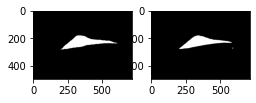

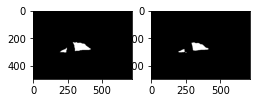

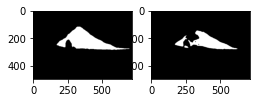

[[0.9958952888620325, nan, 0.7489661240651122, nan], [0.9993260162073618, nan, 0.9654713493530499, nan], [0.9970681868660695, nan, 0.9362729320888317, nan], [0.9987458470566238, nan, 0.9216531895777179, nan], [0.9805656185577327, nan, 0.7781585560886451, nan]]
0.9322123108723177


In [25]:
import os, logging, traceback
def get_labels(label_sample_path, num_samples=128):
    # sort the image dir in numerical ascend order
    label_images = []
    image_names = os.listdir(label_sample_path)
    image_names.sort(key=natural_keys)
    for i, image_name in enumerate(image_names):
        label_image = cv2.imread(os.path.join(label_sample_path, image_name))[:,:,0]
        label_images.append(label_image)
    return label_images
def aic_fundus_lesion_segmentation(ground_truth, prediction, num_samples=128):
    """
    Detection task auc metrics.
    :param ground_truth: numpy matrix, (num_samples, 1024, 512)
    :param prediction: numpy matrix, (num_samples, 1024, 512)
    :param num_samples: int, default 128
    :return list:[Dice_0, Dice_1, Dice_2, Dice_3][background,REA,SRF,PED]
    """
#     assert (ground_truth.shape == (num_samples, 1024, 512))
#     assert (prediction.shape == (num_samples, 1024, 512))

    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()
    try:
        ret = [0.0, 0.0, 0.0, 0.0]
        for i,target in enumerate([0,255,191,128]):
            mask1 = (ground_truth == target)
            mask2 = (prediction == target)
            if mask1.sum() != 0:
                ret[i] = float(2 * ((mask1 * (ground_truth == prediction)).sum())) / (mask1.sum() + mask2.sum())
            else:
                ret[i] = float('nan')
    except Exception as e:
        traceback.print_exc()
        print("ERROR msg:", e)
        return None
    return ret
def get_dice_score(ground_truths, predictions):
    """get dice score per sample"""
    dice_scores, valid_scores = [], []
    for i in range(len(ground_truths)):
        type_scores = aic_fundus_lesion_segmentation(ground_truths[i], predictions[i])
        dice_scores.append(type_scores)
        for type_score in type_scores:
            if not math.isnan(type_score):
                valid_scores.append(type_score)  
    return dice_scores, np.mean(valid_scores)

vallabel_root = "./data/Edema_testset_1/final_label"
sample_labels = get_labels(vallabel_root)

#sample_labels = [get_labels("./data/Edema_validationset/label_images/P0067_MacularCube512x128_4-28-2014_17-15-21_OS_sn21294_cube_z_labelMark")]
labels,predictions = [],[]

for sample_idx in range(len(sample_labels)):
    label = np.array(sample_labels[sample_idx])
#     for target_pixel in config.label_dict:
#         np.place(label, label==target_pixel, config.label_dict[target_pixel])
    
    prediction = np.array(sample_predictions[0][sample_idx])
    label=label[:,50:]
    prediction=prediction[:,50:]
    prediction=decode_segmap(prediction)
    prediction[prediction==255]=0
    prediction[prediction==128]=0
    plt.subplot(132)
    plt.imshow(label, cmap = "gray")
    plt.subplot(133)
    plt.imshow(prediction, cmap = "gray")
    plt.show()    
    labels.append(label)
    predictions.append(prediction)
    label_im=Image.fromarray(label)
    label_im.save("/opt/models/AIChallenger_OCT/data/Edema_testset_1/result/{}_label.bmp".format(sample_idx+1))
    predict_im=Image.fromarray(np.uint8(prediction))
    predict_im.save("/opt/models/AIChallenger_OCT/data/Edema_testset_1/result/{}_predict.bmp".format(sample_idx+1))
sample_dices,mean_dice=get_dice_score(labels,predictions)
print(sample_dices)
print(mean_dice)

In [27]:
np.array(sample_dices[:,0])

TypeError: list indices must be integers or slices, not tuple

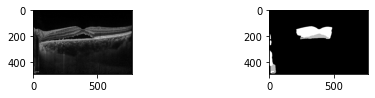

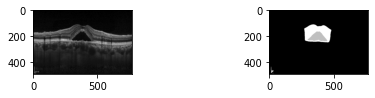

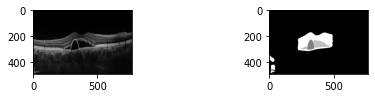

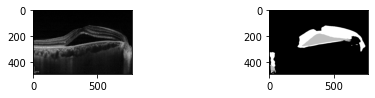

IndexError: index 4 is out of bounds for axis 0 with size 4

In [11]:
sample_idx = 0
for image_idx in range(9):
    image = np.squeeze(sample_images[sample_idx][image_idx])
#     label = sample_labels[sample_idx][image_idx]
    prediction = sample_predictions[sample_idx][image_idx]
    plt.figure()
    plt.subplot(131)
    plt.imshow(image, cmap = "gray")
#     plt.subplot(132)
#     plt.imshow(label, cmap = "gray")
    plt.subplot(133)
    plt.imshow(decode_segmap(prediction), cmap = "gray")
    plt.show()

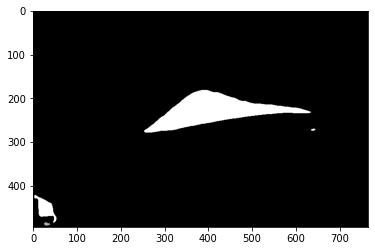

191


In [85]:
img=decode_segmap(prediction)
img[img==255]=0
plt.imshow(img,cmap='gray')
plt.show()
print(img.max())

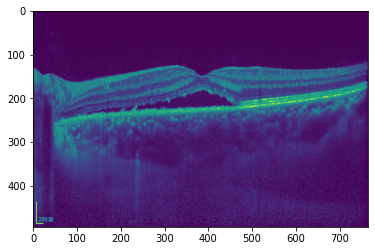

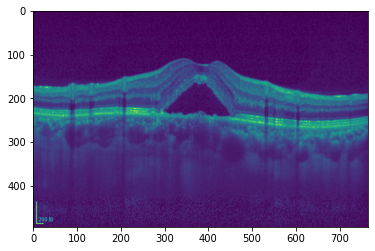

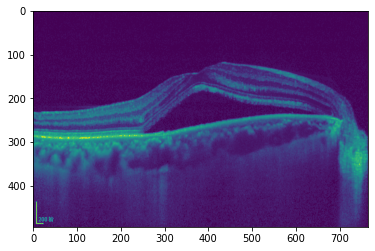

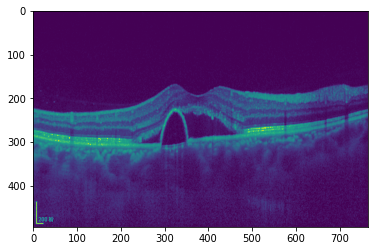

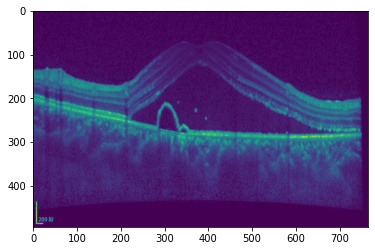

FileNotFoundError: [Errno 2] No such file or directory: '/opt/models/AIChallenger_OCT/data/Edema_testset_1/final_ori/6.jpg'

In [11]:
#原图裁剪+直方图匹配
from skimage.exposure import match_histograms
img1=Image.open("/opt/models/AIChallenger_OCT/data/Edema_testset_1/P0089_MacularCube512x128_4-25-2013_9-32-13_OD_sn2218_cube_z.img/1.bmp")
img1=np.array(img1)
fileNames="/opt/models/AIChallenger_OCT/data/Edema_testset_1/final_ori"
for i in range(len(os.listdir(fileNames))):
    img = np.array(Image.open(fileNames + "/{}.jpg".format(i+1)))
    if img.shape[0]!=596:
        img_crop= Image.fromarray(img[:485,-508:])
        img_crop=img_crop.convert('L')       
    else:
        img_crop= Image.fromarray(img[:494,-765:])
        img_crop=img_crop.convert('L')
    img=np.array(img_crop)
    matched= match_histograms(img,img1)
    matchedImage=Image.fromarray(matched)
    matchedImage=matchedImage.convert('L')
    plt.imshow(matchedImage)
    plt.show()
    matchedImage.save("/opt/models/AIChallenger_OCT/data/Edema_testset_1/original_images/final_processed/{}.bmp".format(i+1))
        


<ipython-input-10-851c442cf2e8>:8: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  img_flip=img.transpose(Image.FLIP_LEFT_RIGHT)
<ipython-input-10-851c442cf2e8>:9: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  img_flip=np.array(img.transpose(Image.FLIP_LEFT_RIGHT))


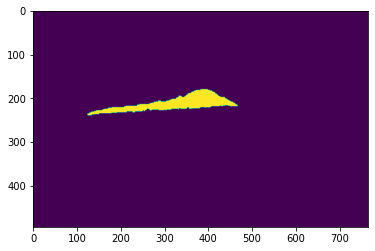

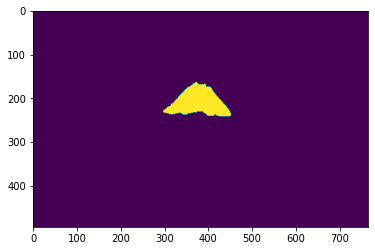

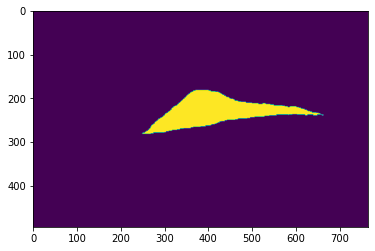

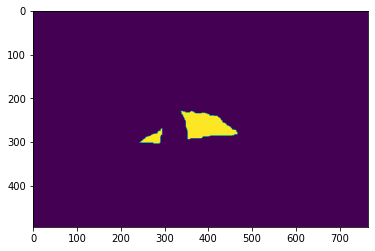

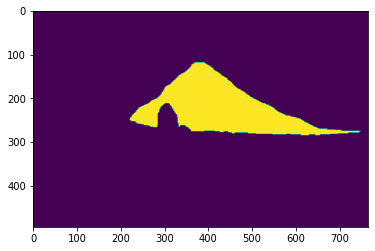

In [10]:
#生成标签
import nrrd
fileName='/opt/models/AIChallenger_OCT/data/Edema_testset_1/final'
for i in range(5):
    data,options=nrrd.read(fileName+'/{}_mask.nrrd'.format(i+1))
    img=Image.fromarray(data[:,:,0])
    img=img.rotate(270,expand = 1)
    img_flip=img.transpose(Image.FLIP_LEFT_RIGHT)
    img_flip=np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
#     plt.imshow(img_flip)
#     plt.show()
    if img_flip.shape[0]!=596:
        img_crop= Image.fromarray(img_flip[:485,-508:])
    else:
        img_crop= Image.fromarray(img_flip[:494,-765:])
    img=np.array(img_crop)
    img[img==1]=191
    img_crop=Image.fromarray(img)
    img_crop=img_crop.convert('L')
    plt.imshow(img_crop)
    plt.show()
    img_crop.save("/opt/models/AIChallenger_OCT/data/Edema_testset_1/final_label/{}.bmp".format(i+1))

In [129]:
fileName='/opt/models/AIChallenger_OCT/data/Edema_testset_1/final_label'
for i in range(4):
    img=np.array(Image.open(fileName+'/{}.bmp'.format(i+1)))
    img[img==1]=191
    img=Image.fromarray(img)
    img.save("/opt/models/AIChallenger_OCT/data/Edema_testset_1/final_label/{}_label.bmp".format(i+1))

In [60]:
label=Image.open('/opt/models/AIChallenger_OCT/data/Edema_validationset/label_images/P0067_MacularCube512x128_4-28-2014_17-15-21_OS_sn21294_cube_z_labelMark/29.bmp')
print(np.array(label).max())

255
